In [1]:
import os
from os import path
import random

import cv2
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import evaluate

from PIL import Image

from transformers import VisionEncoderDecoderModel, AutoTokenizer, TrOCRProcessor
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import default_data_collator

from data_aug_v2 import build_data_aug
from torch.utils.data import Subset
from tang_syn import synthesize

MAX_LENGTH = 64

class OCRDataset(Dataset):

    def __init__(self,
                 dataset_dir,
                 labels_dir,
                 transform,
                 processor,
                 tokenizer,
                 mode="train",
                 max_target_length=32,
                 device=None):
        self.dataset_dir = dataset_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.device = device
        self.processor = processor
        self.mode = mode
        self.max_target_length = max_target_length
        self.tokenizer = tokenizer
        self.df = self.build_df()
        self.df_len = len(self.df)
        self.arbitrary_len = 12000000

    def __len__(self):
        return self.arbitrary_len

    def __getitem__(self, idx):

        # Thirty percent of the time, use existing dataset
        if idx < self.df_len:
            text = self.df['text'][idx]
            # get file name + text
            file_name = self.df["file_name"][idx]
            # prepare image (i.e. resize + normalize)
            image = Image.open(path.join(self.dataset_dir,
                                         file_name)).convert("RGB")
        # 70% percent of the time, use online generated data
        else:
            text_idx = int(idx / self.arbitrary_len * (self.df_len - 1))
            text = self.df['text'][text_idx]
            bgr_image = synthesize(text)
            rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(rgb_image)

        if self.transform:
            image = self.transform(image)

        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        # Remove spaces from text, as only the tang-syn version 1 had spaces before text
        text = text.strip()
        labels = self.tokenizer(text,
                                padding="max_length",
                                stride=32,
                                truncation=True,
                                max_length=self.max_target_length).input_ids

        # important: make sure that PAD tokens are ignored by the loss function
        labels = [
            label if label != self.tokenizer.pad_token_id else -100
            for label in labels
        ]

        encoding = {
            "text": text,
            "pixel_values": pixel_values.squeeze(),
            "labels": torch.tensor(labels),
            "image": image
        }
        return encoding

    def build_df(self):
        li = []
        for root, _dirs, files in os.walk(self.labels_dir):
            for file in files:  # Loop through the dataset tsvfiles
                if not file.endswith(".tsv"):
                    continue

                print(f"Processing {file}")
                li.append(
                    pd.read_table(path.join(root, file),
                                  names=["file_name", "text"]))

        return pd.concat(li, axis=0, ignore_index=True)
    
class EvalDataset(OCRDataset):

    def __len__(self):
        return len(self.df)


def load_datasets(processor, tokenizer):
    dataset_dir = 'dataset/data'

    train_dataset = OCRDataset(dataset_dir=dataset_dir,
                               labels_dir="dataset/labels/train",
                               tokenizer=tokenizer,
                               processor=processor,
                               mode="train",
                               transform=build_data_aug(32, "train"),
                               max_target_length=MAX_LENGTH)

    # Define the number of samples to keep in eval dataset

    eval_dataset = EvalDataset(dataset_dir=dataset_dir,
                               labels_dir="dataset/labels/test",
                               tokenizer=tokenizer,
                               processor=processor,
                               mode="eval",
                               transform=None,
                               max_target_length=MAX_LENGTH)

    # Create a random subset of the dataset
    num_samples = 100
    subset_indices = torch.randperm(len(eval_dataset))[:num_samples]
    eval_dataset = Subset(eval_dataset, subset_indices.tolist())

    print("Number of training examples:", len(train_dataset))
    print("Number of validation examples:", len(eval_dataset))

    return train_dataset, eval_dataset

model_pth = "checkpoints/checkpoint-6000"

tokenizer = AutoTokenizer.from_pretrained(model_pth)
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset, eval_dataset = load_datasets(processor=processor, tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

pygame 2.4.0 (SDL 2.26.4, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


100%|██████████| 1669/1669 [00:02<00:00, 687.54it/s]


Usable font: 1548


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Processing digit_95k.tsv
Processing hand_line_all_548k.tsv
Processing tang_syn_1577k.tsv
Processing web_line_238k.tsv
Processing hw_chinese_240k.tsv
Processing hwdb_ic13_47k.tsv
Processing hwdb2.1_13k.tsv
Processing hwdb2.2_12k.tsv
Processing hwdb2.0_16k.tsv
Processing signatures_472k.tsv
Processing hwdb2.0_4k.tsv
Processing hwdb_ic13_3k.tsv
Processing hw_chinese_17k.tsv
Processing hwdb2.2_3k.tsv
Processing hwdb2.1_3k.tsv
Processing hwdb_ic13_val_5k.tsv
Number of training examples: 12000000
Number of validation examples: 100


纷纷扬扬地铺满雪域大地，土司老爷就已经喝
他的我都不认识早晨的
的内胎弹性大
之前先死又
5任党委书记何以忍看百姓⽤臭⽔20年？
顺又傲慢。但在这里：言词逃遁了，沿着外衣
明媚“不，不，她就在赫定顿，读一
痛已然忘记快意的呻吟缓慢的时光于无声处抿
风险评估和信息
任鸿斌


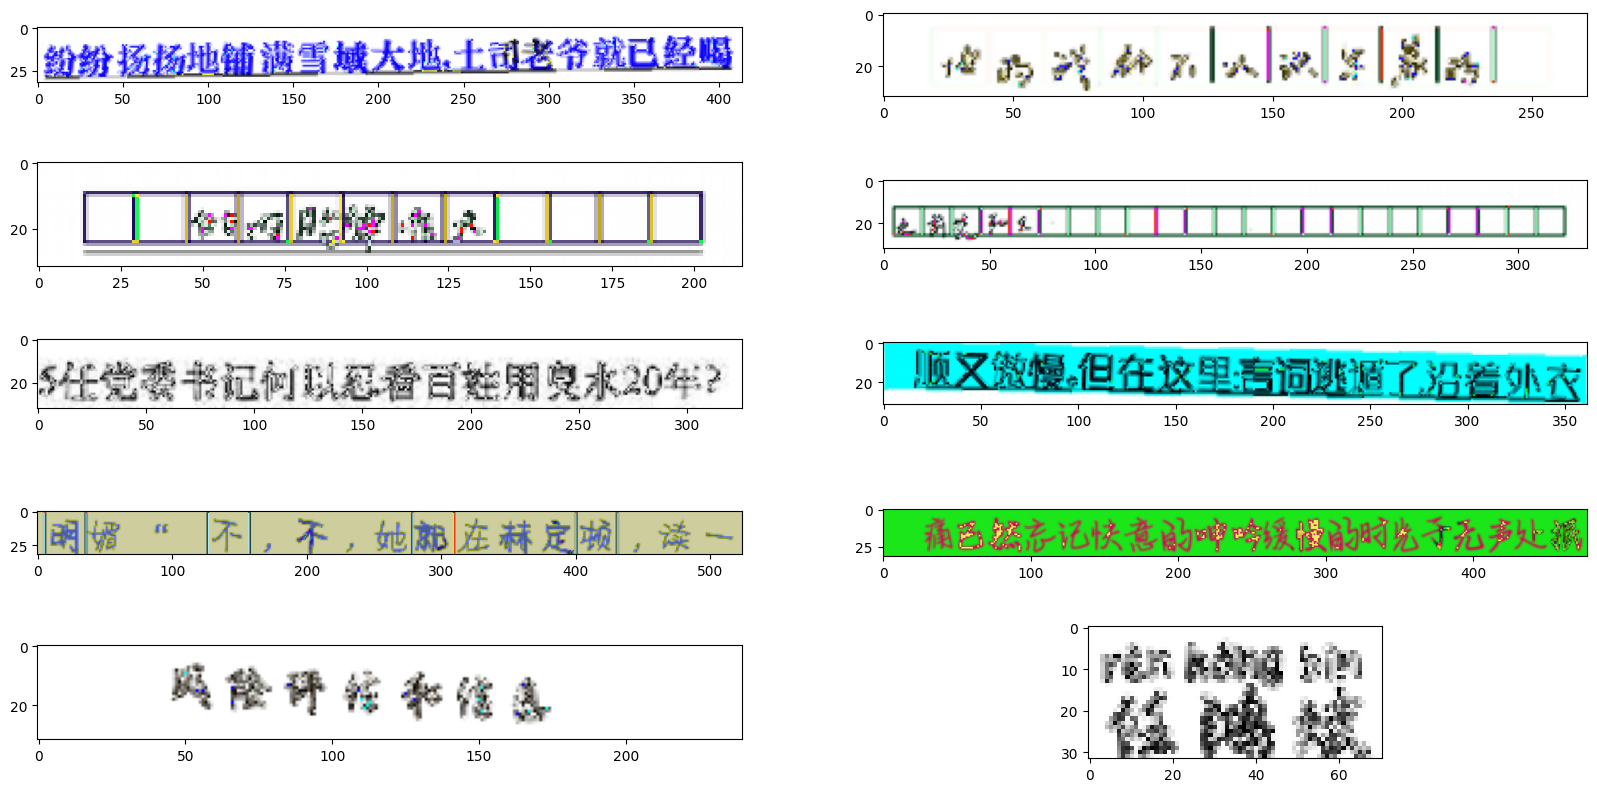

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))  # Set the figure size

length = len(train_dataset)


for i in range(10):

    random_index = random.randint(0, length - 1)
    res = train_dataset[random_index]

    plt.subplot(5, 2, i+1)  # Create a subplot for each image
    plt.imshow(res["image"])  # Display the image

    print(res["text"])

plt.show()